In [1]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[4:7], device_type = 'GPU' )

### 1. 获取所有图像、标签的路径：

In [5]:
image_path = glob.glob( '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/*.jpg' )
label_path = glob.glob( '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/*.png' )

In [6]:
# 抽查是否对应：不对应！！
image_path[123:125], label_path[123:125]

(['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_228.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_230.jpg'],
 ['/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Abyssinian_220.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Abyssinian_221.png'])

In [7]:
# 排序：
image_path.sort( key = lambda x:x.split('/')[-1].split('.')[0].split('_')[-1] )
label_path.sort( key = lambda x:x.split('/')[-1].split('.')[0].split('_')[-1] )
# 再抽查：
image_path[1029:1033], label_path[1029:1033]

(['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/beagle_125.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Bengal_125.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Birman_125.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Bombay_125.jpg'],
 ['/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/beagle_125.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Bengal_125.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Birman_125.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Bombay_125.png'])

In [8]:
len(image_path), len(label_path)

(7390, 7390)

说明：自定义的网络，意思就是FCN网络的前半部分也用自己定义的网络（还是照着VGG16来），也同样要参与到训练中！

### 2. 创建、划分数据集：

In [9]:
dataset = tf.data.Dataset.from_tensor_slices( (image_path, label_path) )

In [11]:
# 划分训练、测试集
test_count = int( len(image_path)*0.2 )
train_count = len(image_path) - test_count

train_dataset = dataset.skip(test_count)  # 跳过前这么多数据
test_dataset = dataset.take(test_count)   # 取前面这么多数据

### 3. 文件预处理函数：解码、归一化、尺寸统一！

In [12]:
# 文件读取 + 解码函数：原图是jpg，标签图是png
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)  # 记得加通道，否则是None！
    return img

def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [13]:
# 预处理函数：
def normal_image(image, label):
    # 对原图的处理：转换数据类型 + 归一化[-1,1]
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1
    # 对标签图的处理：它的取值范围是[1,2,3]，但习惯于从0开始[0,1,2]！故都减去1
    label = label - 1
    return image, label

In [14]:
# 总加载函数：
new_height = 224
new_weight = 224

def load_image( image_path, label_path ):
    # 对原图的处理：
    image = read_jpg(image_path)
    image = tf.image.resize(image, (new_height, new_weight))  # 尺寸统一
    # 对标签图的处理：
    label = read_png(label_path)
    label = tf.image.resize(label, (new_height, new_weight))  # 尺寸统一
    
    return normal_image(image, label)

In [15]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_image, num_parallel_calls = AUTOTUNE )
test_dataset = test_dataset.map( load_image, num_parallel_calls = AUTOTUNE )

In [16]:
# 最后的乱序（让每个epoch的训练，看到的图像顺序不一样！）、batch划分：
BATCH_SIZE = 32  # 跟显存有关！
train_dataset = train_dataset.shuffle(train_count).repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
# 查看最后的数据：
train_dataset, test_dataset

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>)

### 4. 使用自定义网络：前半部 + 后半部 —— 必须一起定义！

In [15]:
inputs = tf.keras.layers.Input( shape = (224,224,3) )

In [16]:
# 前半部分卷积基自定义：顺序连接 + 用名字获得某层输出
# 第一部分：
conv2d_1 = tf.keras.layers.Conv2D( 64, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_1' )(inputs)
conv2d_2 = tf.keras.layers.Conv2D( 64, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_2' )(conv2d_1)
maxpool1 = tf.keras.layers.MaxPooling2D( name = 'maxpool1' )(conv2d_2)
# 第二部分：
conv2d_3 = tf.keras.layers.Conv2D( 128, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_3' )(maxpool1)
conv2d_4 = tf.keras.layers.Conv2D( 128, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_4' )(conv2d_3)
maxpool2 = tf.keras.layers.MaxPooling2D( name = 'maxpool2' )(conv2d_4)
# 第三部分：
conv2d_5 = tf.keras.layers.Conv2D( 256, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_5' )(maxpool2)
conv2d_6 = tf.keras.layers.Conv2D( 256, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_6' )(conv2d_5)
conv2d_7 = tf.keras.layers.Conv2D( 256, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_7' )(conv2d_6)
maxpool3 = tf.keras.layers.MaxPooling2D( name = 'maxpool3' )(conv2d_7)
# 第四部分：
conv2d_8 = tf.keras.layers.Conv2D( 512, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_8' )(maxpool3)
conv2d_9 = tf.keras.layers.Conv2D( 512, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_9' )(conv2d_8)
conv2d_10 = tf.keras.layers.Conv2D( 512, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_10' )(conv2d_9)
maxpool4 = tf.keras.layers.MaxPooling2D( name = 'maxpool4' )(conv2d_10)
# 第五部分：
conv2d_11 = tf.keras.layers.Conv2D( 512, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_11' )(maxpool4)
conv2d_12 = tf.keras.layers.Conv2D( 512, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_12' )(conv2d_11)
conv2d_13 = tf.keras.layers.Conv2D( 512, (3,3), strides = (1,1), activation = 'relu', padding = 'same', name = 'conv2d_13' )(conv2d_12)
maxpool5 = tf.keras.layers.MaxPooling2D( name = 'maxpool5' )(conv2d_13)

In [17]:
# 直接用名字就可以查看某层的输出：无需再使用.output属性！
# 按顺序列出后面会用到的层：
maxpool5, conv2d_13, conv2d_10, conv2d_7, conv2d_4

(<tf.Tensor 'maxpool5/Identity:0' shape=(None, 7, 7, 512) dtype=float32>,
 <tf.Tensor 'conv2d_13/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'conv2d_10/Identity:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'conv2d_7/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'conv2d_4/Identity:0' shape=(None, 112, 112, 128) dtype=float32>)

FCN后半部分自定义搭建：

In [18]:
# 1. 对maxpool5层进行上采样，升为(14,14,512)；卷积后和conv2d_13合并：
x1 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same', activation = 'relu', name = 'x1' )(maxpool5)
# 加一层卷积：
conv_x1 = tf.keras.layers.Conv2D(512, 3, strides=(1,1), padding='same', activation='relu', name = 'conv_x1')(x1)  # 卷积提取一下特征
# 第1次跳接：conv_x1和conv2d_13合并
x2 = tf.add(conv_x1, conv2d_13)
x2.shape

TensorShape([None, 14, 14, 512])

In [19]:
# 2. 对x2层进行上采样，升为(28,28,512)；卷积后和conv2d_10合并：
x3 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same', activation='relu', name = 'x3')(x2)
# 加一层卷积：
conv_x3 = tf.keras.layers.Conv2D(512, 3, strides=(1,1), padding='same', activation='relu', name = 'conv_x3')(x3)
# 第2次跳接：conv_x3和conv2d_10合并
x4 = tf.add(conv_x3, conv2d_10)
x4.shape

TensorShape([None, 28, 28, 512])

In [20]:
# 3. 对x4层进行上采样，升为(56,56,256)；卷积后和conv2d_7合并：
x5 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name = 'x5')(x4)
# 加一层卷积：
conv_x5 = tf.keras.layers.Conv2D(256, 3, strides=(1,1), padding='same', activation='relu', name = 'conv_x5')(x5)
# 第3次跳接：conv_x5和conv2d_7合并
x6 = tf.add(conv_x5, conv2d_7)
x6.shape

TensorShape([None, 56, 56, 256])

In [21]:
# 4. 对x6层进行上采样，升为(112,112,128)；卷积后和conv2d_4合并：
x7 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name = 'x7')(x6)
# 加一层卷积：
conv_x7 = tf.keras.layers.Conv2D(128, 3, strides=(1,1), padding='same', activation='relu', name = 'conv_x7')(x7)
# 第4次跳接：把x7和conv2d_4合并
x8 = tf.add(conv_x7, conv2d_4)
x8.shape

TensorShape([None, 112, 112, 128])

In [22]:
# 5. 最后只用把x8层上采样，升为(224,224,3)即可：多分类，用softmax！
x9 = tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='softmax', name = 'x9')(x8)
x9.shape

TensorShape([None, 224, 224, 3])

In [23]:
# 整个模型创建：
model = tf.keras.Model( inputs = inputs, outputs = x9 )

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 112, 112, 64) 0           conv2d_2[0][0]                   
______________________________________________________________________________________________

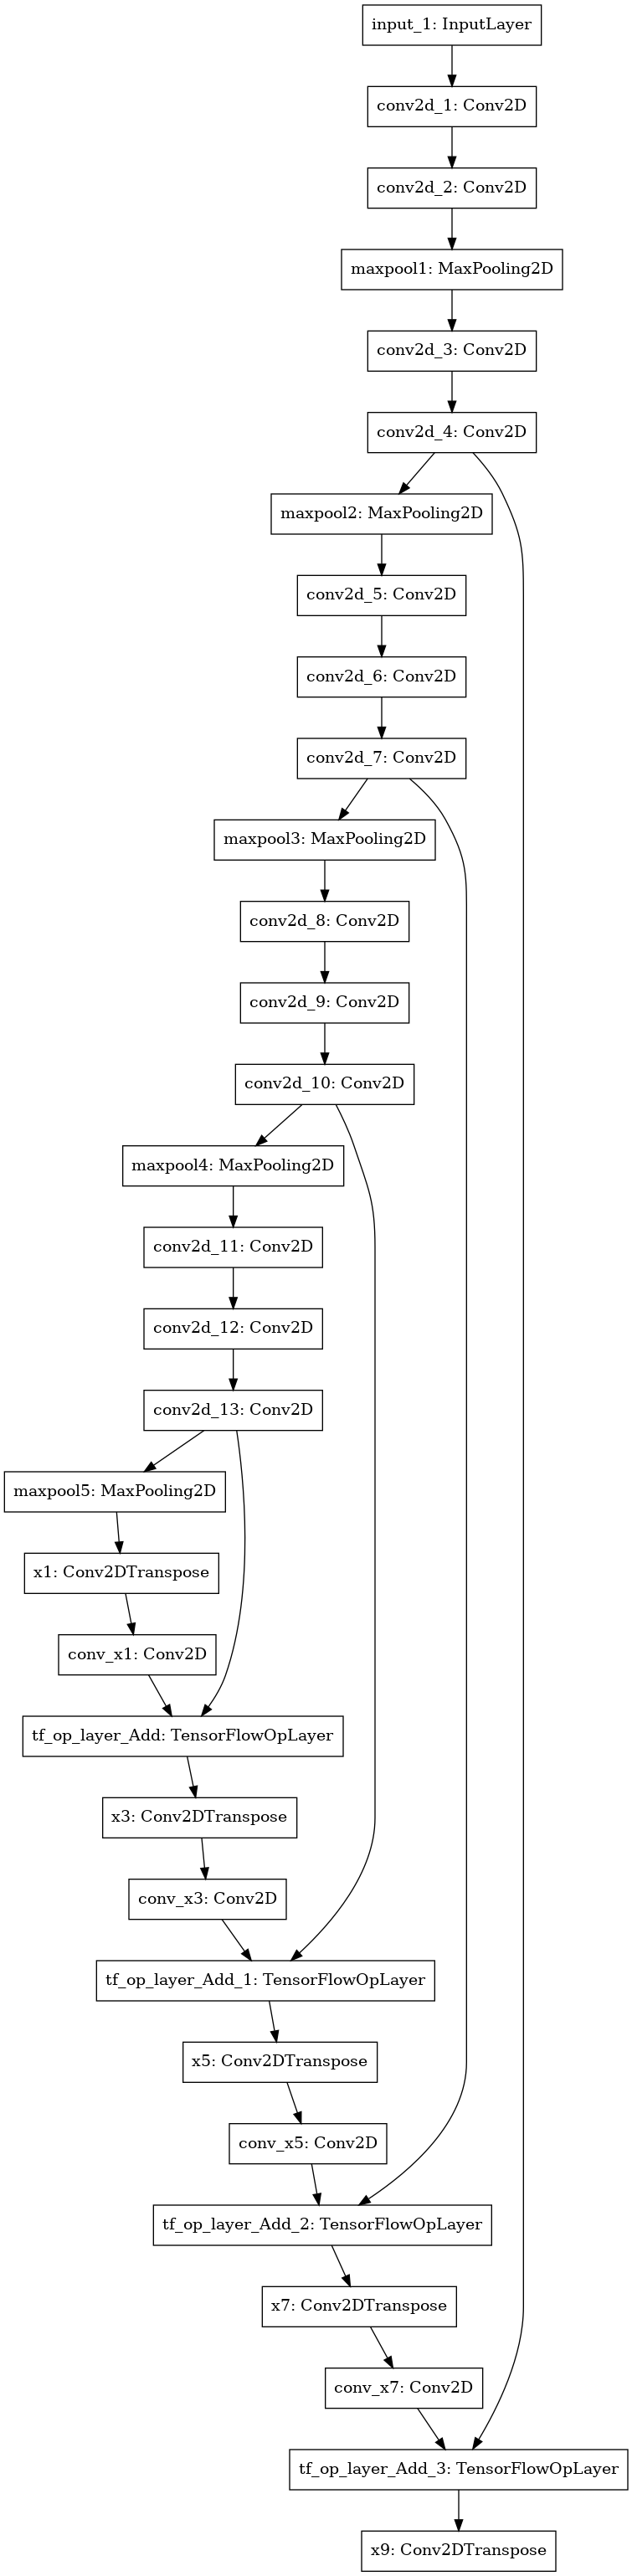

In [25]:
# 画出网络拓扑图：
tf.keras.utils.plot_model(model, show_shapes = False, expand_nested = False, to_file = 'FCN自定义跳接网络.png')

In [26]:
# 模型编译：
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [27]:
# 设置保存的路径：
checkpoint_path = '/home/gaoboyu/学习保存的模型/FCN'
# 设置回调函数保存模型：没设置的参数都默认
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_acc',
    save_best_only = True  # 监控的目标：如果新的epoch结果比前一个要好，那就重新保存最新的，删掉旧的！
)

In [29]:
# 模型训练：
EPOCHS = 20
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = test_dataset,
    validation_steps = test_count // BATCH_SIZE,
    callbacks = [cp_callback]
)

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.8175 - acc: 0.6299WARNING:tensorflow:From /usr/local/Anaconda33/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gaoboyu/学习保存的模型/FCN/assets
184/184 [==============================] - 292s 2s/step - loss: 0.8175 - acc: 0.6299 - val_loss: 0.6416 - val_acc: 0.7307
Epoch 2/20
184/184 [==============================] - 285s 2s/step - loss: 0.5990 - acc: 0.7514 - val_loss: 0.4997 - val_acc: 0.7952
Epoch 3/20
184/184 [==============================] - 288s 2s/step - loss: 0.4917 - acc: 0.8022 - val_loss: 0.4363 - val_acc: 0.8236
Epoch 4/20
184/184 [==============================] - 287s 2s/step - loss: 0.4405 - ac

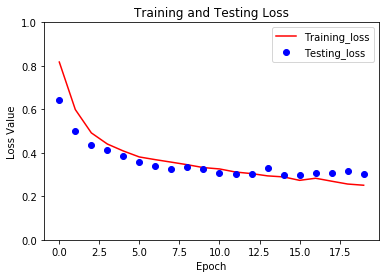

In [30]:
# 绘制loss曲线：
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, train_loss, 'r', label = 'Training_loss')
plt.plot(epochs, test_loss, 'bo', label = 'Testing_loss')
plt.title( 'Training and Testing Loss' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss Value' )
plt.ylim( [0,1] )
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


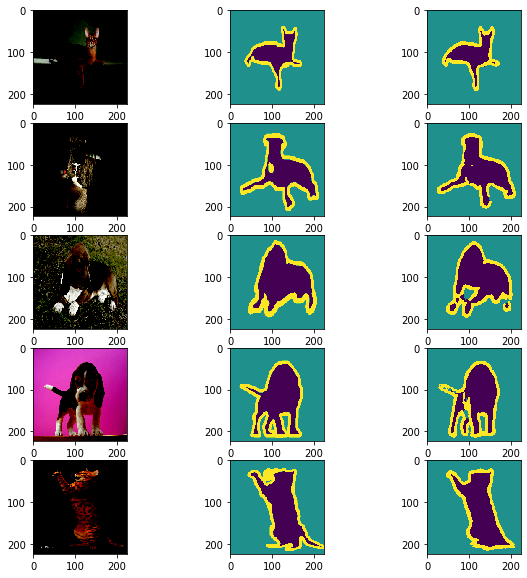

In [31]:
# 在测试数据上看效果：
num = 5 # 一次看5张效果！

for image, label_real in test_dataset.take(1):
    label_pred = model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！变成(224,224)
    
    plt.figure( figsize=(10,10) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( image[i] )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(224,224) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy() )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


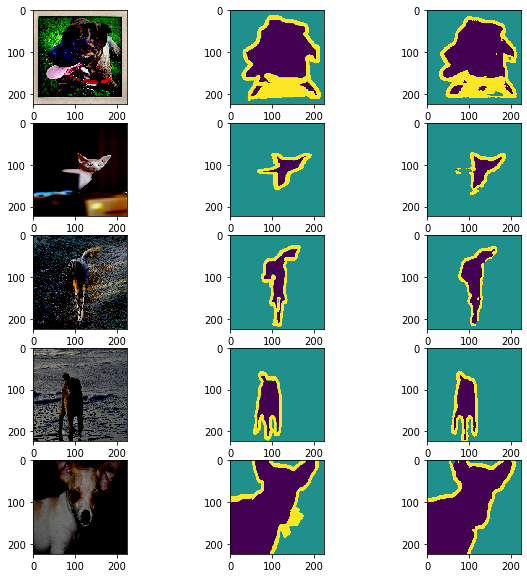

In [32]:
# 在实际数据上看效果：
num = 5 # 一次看5张效果！

for image, label_real in train_dataset.take(1):
    label_pred = model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！变成(224,224)
    
    plt.figure( figsize=(10,10) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( image[i] )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(224,224) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy() )

In [2]:
# 模型加载：因为保存的是全体模型，所以直接直接导入即可（和导入.h5文件方式一样！）
new_model = tf.keras.models.load_model( '/home/gaoboyu/学习保存的模型/FCN' )  # 括号里写model的地址

In [3]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 112, 112, 64) 0           conv2d_2[0][0]                   
______________________________________________________________________________________________

In [19]:
new_model.evaluate( test_dataset )

47/47 [==============================] - 22s 464ms/step - loss: 0.3015 - acc: 0.8849


[0.30147555470466614, 0.8849411010742188]